In [2]:

import numpy as np
import h5py
from scipy.differentiate import derivative
from scipy.optimize import curve_fit, root, root_scalar
from matplotlib import pyplot as plt
from math import erf

rho_b=810
M_w=18.001528e-3 # molar mass of water
M_a=28.9647e-3 # molar mass of air
R=8.314462618 # universal gas constant
k_B=1.380649e-23 # Boltzmann constant
N_a=6.02214076e23 # Avogadro constant
L_s=2.834e6 # J/kg latent heat of sublimation
# thermal conductivity of moist air
# K = 0.024 # W/m/K
# cp = 1005 # J/kg/K specific heat capacity of air at constant pressure
beta_d=1.0 # thermal accommodation coefficient

alpha_d=0.036 # deposition coefficient - this affects the growth rate at small masses (m0, gamma)

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


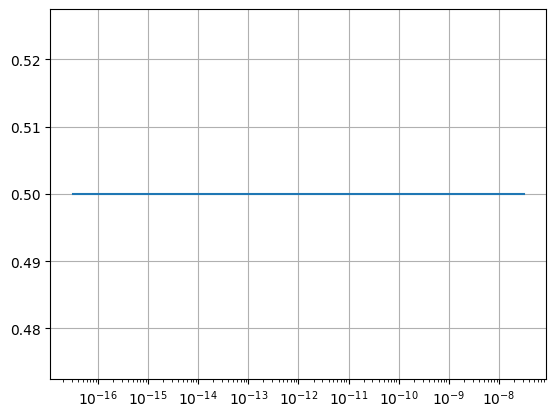

In [3]:
def c_a(m):
    m_t = 2.146e-1 # transition mass
    alpha = np.where(m<m_t,526.1,0.04142)
    beta = np.where(m<m_t,3.0,2.2)
    
    return np.where(m<m_t,0.99999999,np.sqrt(np.sqrt(27)*rho_b/(8*alpha**(3/beta)))*m**((3-beta)/(2*beta)))


def e_prolate(m):
    return (1 - 1/np.astype(c_a(m),complex) ** 2)**0.5

def L(m):
    return 2* (m * c_a(m) **2 / (rho_b * 4 / 3 * np.pi)) ** (1 / 3)

def C(m):
    # capacitance of spheroid - affects growth rate at high masses (delta)
    e = e_prolate(m) # eccentricity
    return np.abs(L(m) * e / (np.log((1 + e) / (1 - e))))

def A(m):
    # surface area of spheroid
    e = e_prolate(m)

    return np.where(e > 0, 0.5 * np.pi * L(m) ** 2 * (1 + c_a(m) / e * np.arcsin(e)), np.pi * L(m) ** 2).real



mass=np.logspace(-16.5,-7.5,1000)
e_prolate(mass)
plt.semilogx(mass,C(mass)/L(mass))
plt.grid(True)
# 
# plt.loglog(m,c_a(m)*D(m)/2)

1.8361244967511803e-05


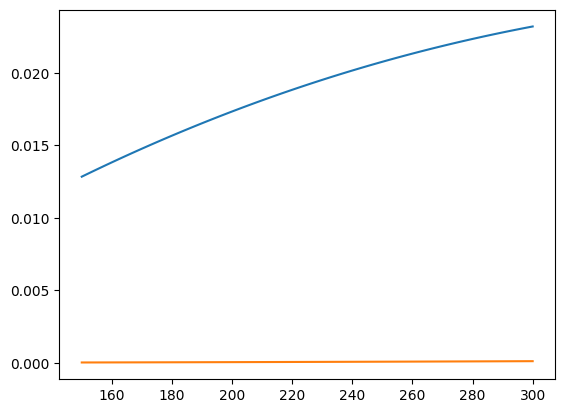

In [4]:
def mu_air(T):
    sigma_air = 3.617e-10 # m
    Tstar = T/97.0
    Omega = 1.16145*Tstar**-0.14874+0.52487*np.exp(-0.77320*Tstar)+2.16178*np.exp(-2.43787*Tstar)
    return 5/(16*np.pi**0.5)*(M_a/N_a*k_B*T)**0.5/(sigma_air**2*Omega)

print(mu_air(298.15))

def psat_water(p, T):
    ew = np.exp(-6096.9385 / T + 21.2409642 - 2.711193e-2 * T + 1.673952e-5 * T ** 2 + 2.433502 * np.log(T))
    fw = 1.0016 + 3.15e-8 * p - 7.4e-4 / p
    return ew * fw


def psat_ice(p, T):
    ei = np.exp(-6024.528211 / T + 29.32707 + 1.0613868e-2 * T + -1.3198825e-5 * T ** 2 - 0.49382577 * np.log(T))
    fi = 1.0016 + 3.15e-8 * p - 7.4e-4 / p
    return ei * fi

def D_v(p,T):
    return 2.11e-5*(T/273.15)**1.94*(101325/p)

def cp_air(T):
    return 1000*(1.3864e-15*T**3-6.4747e-10*T**3+1.0234e-6*T**2-4.3282e-4*T+1.0613)

def k_air(T):
    return 1.5797e-17*T**5+9.46e-14*T**4+2.2012e-10*T**2-2.3758e-7*T**2+1.7082e-4*T-7.488e-3

def cp_wvap(T):
    return 1000*(5.7610e-15*T**5-1.8160e-11*T**4+1.9848e-8*T**3-7.5368e-6*T**2+6.6923e-5*T+2.3082)

def k_wvap(T):
    return 1.0143e-4*T-1.3898e-2


def u_r(T):
    return np.sqrt(2*k_B*T/(np.pi*M_a/N_a))

p=21000
T=np.linspace(150,300,100)
plt.plot(T,k_air(T))
f=(psat_ice(p,T)/p)*M_w/M_a
plt.plot(T,D_v(p,T))


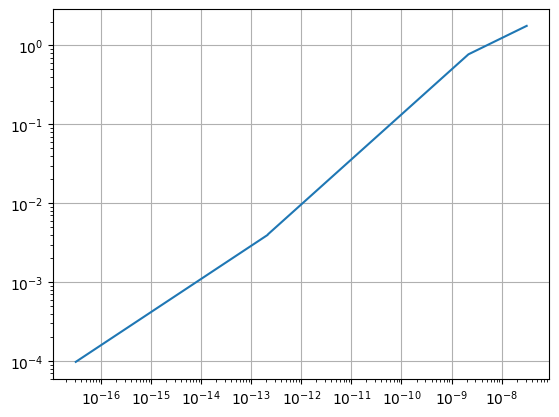

In [5]:
def u_terminal(m,p,T):
    m1=2.146e-13
    m2=2.166e-9
    m3=4.264e-8

    gamma_choices = [735.4, 59000, 329.8, 8.8] # 63292.4
    delta_choices = [0.42, 0.57, 0.31, 0.096]
    conditions = [m <= m1, (m > m1) & (m <= m2), (m > m2) & (m <= m3), m >= m3]

    gamma = np.select(conditions, gamma_choices)
    delta = np.select(conditions, delta_choices)

    c = (p/30000)**-0.178*(T/233)**-0.394
    return c*gamma * m**delta

plt.loglog(mass,u_terminal(mass,21000,200))
plt.grid(True)

    

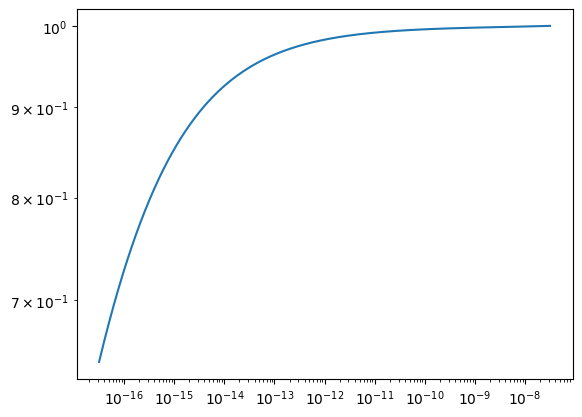

In [6]:

def f1(T_s,p,T,m,Sc,Re):
    rstar = A(m)/(4*np.pi*C(m))
    lstar_M = 2*np.pi*M_w/(R*T_s)*D_v(p,T)*f2(Sc,Re)/(2*alpha_d/(2-alpha_d))#D_v(p,T)
    
    return rstar/(rstar+lstar_M)


def f1star(p,T,m,Pr,Re):
    rho_a=p*M_a/(R*T)
    rstar = A(m)/(4*np.pi*C(m))
    lstar_Q = k_air(T)*f2(Pr,Re)/(rho_a**(1/4)*u_r(T)*beta_d*cp_air(T))
    return rstar/(rstar+lstar_Q)

def f2(N1, N2):
    a = N1 ** (1 / 3) * N2 ** (1 / 2)
    return np.where(a<=1, 1+0.14*a**2, 0.86+0.28*a)

T=200
p=21000
rho_a=p*M_a/(R*T)
Pr=mu_air(T)*cp_air(T)/k_air(T) # Prandtl number
Re_thermal= rho_a * u_terminal(mass,p,T) * L(mass) / mu_air(T)
x=0
while ((Re_thermal-x)/Re_thermal>1e-4).any():
    x=Re_thermal
    lstar_Q = k_air(T)*f2(Pr,Re_thermal)/(rho_a**(1/4)*u_r(T)*beta_d*cp_air(T))
    Re_thermal=rho_a*u_terminal(mass,p,T)*lstar_Q/mu_air(T)

plt.loglog(mass,f2(Pr,Re_thermal)*f1star(p,T,mass,Pr,Re_thermal))


In [7]:
class Lognormal:
    def __init__(self,N,mu,sigma):
        self.N = N
        self.mu = mu
        self.sigma = sigma
    def pdf(self,x):
        return self.N/(x*np.log(self.sigma)*np.sqrt(2*np.pi))*np.exp(-(np.log(x/self.mu))**2/(2*np.log(self.sigma)**2))
    def cdf(self,x):
        return self.N/2*(1+np.array(list(map(erf, (np.log(x/self.mu))/(np.log(self.sigma)*np.sqrt(2))))))
    

In [8]:
def mass_flux_ice(T,p,rho_w,m,T_s):
 
    rho_a=p*M_a/(R*T) # density of air
    Sc=mu_air(T)/rho_a/D_v(p,T) # Schmidt number
    Re= rho_a * L(m) * u_terminal(m, p, T) / mu_air(T)
    
    # T_s is given, p_s is psat(T_s), rho_s is derived
    rho_w_surf = psat_ice(p,T_s)*M_w/(R*T_s)
    
    return 4*np.pi*C(m)*D_v(p,T)*f1(T_s,p,T,m,Sc,Re)*f2(Sc,Re)*(rho_w-rho_w_surf)

def heat_flux_ice(T,p,rho_w,m,T_s):
    rho_a=p*M_a/(R*T) # density of air
    Pr=mu_air(T)*cp_air(T)/k_air(T) # Prandtl number
    Re_thermal= rho_a * u_terminal(m,p,T) * L(m) / mu_air(T)
    for i in range(2):
        lstar_Q = k_air(T)*f2(Pr,Re_thermal)/(rho_a**(1/4)*u_r(T)*beta_d*cp_air(T))
        Re_thermal=rho_a*u_terminal(m,p,T)*lstar_Q/mu_air(T)
    
    return 4*np.pi*C(m)*k_air(T)*f1star(p,T,m,Pr,Re_thermal)*f2(Pr,Re_thermal)*(T_s-T)

In [9]:
def flux_fun(T_s,p,T,rho_w,m):
    rho_a=p*M_a/(R*T) # density of air
    Sc=mu_air(T)/rho_a/D_v(p,T) # Schmidt number
    Re_mass= rho_a * L(m) * u_terminal(m, p, T) / mu_air(T)
    Pr=mu_air(T)*cp_air(T)/k_air(T) # Prandtl number
    Re_thermal= rho_a * u_terminal(m,p,T) * L(m) / mu_air(T)
    x=0
    while ((Re_thermal-x)/Re_thermal).any()>1e-4:
        x=Re_thermal
        lstar_Q = k_air(T)*f2(Pr,Re_thermal)/(rho_a**(1/4)*u_r(T)*beta_d*cp_air(T))
        Re_thermal=rho_a*u_terminal(m,p,T)*lstar_Q/mu_air(T)
    
    rho_w_surf=psat_ice(p,T_s)/(R/M_w*T_s)
    
    return L_s*D_v(p,T)*f1(T_s,p,T,m,Sc,Re_mass)*f2(Sc,Re_mass)*(rho_w-rho_w_surf)+k_air(T)*f1star(p,T,m,Pr,Re_thermal)*f2(Pr,Re_thermal)*(T-T_s)


# plt.plot(np.linspace(180,300,100),flux_fun(np.linspace(180,300,100),30000,200,psat_water(30000,200)/(R/M_w*200),1e-12))

C:\Users\ec765\AppData\Local\Temp\ipykernel_23428\4120111706.py:10: RuntimeWarning: invalid value encountered in power
  return np.where(m<ml,1-np.exp(-(m/m0)**gamma),(m/ml)**delta)*a*m**b


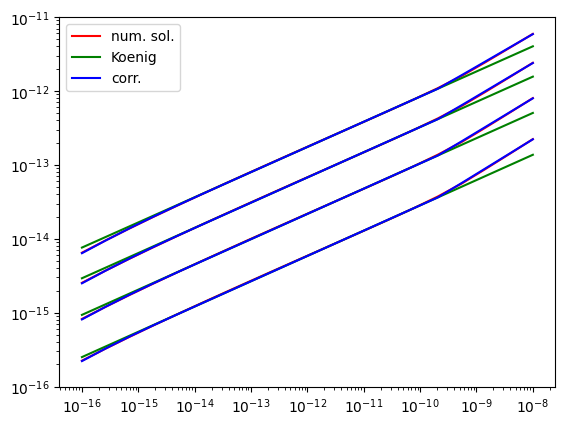

In [10]:
p=30000
m_vals = np.logspace(-16,-8,20)
m_fit = np.logspace(-14,-10,20)

a,b,m0,gamma,delta = 4e-13,0.173,1e-15,0.22,0.12

def fit_fun(a,b):
    ml=2.2e-10
    def f(m,m0,gamma,delta):
        return np.where(m<ml,1-np.exp(-(m/m0)**gamma),(m/ml)**delta)*a*m**b
    return f
    
def fit_fun_koenig(m,a,b):
    return a*m**b

def get_coeffs(p,T):
    a,b,m0,gamma,delta = 4e-13,0.173,1e-15,0.22,0.12
    
    m_inner =  np.logspace(-14,-10,20)
    m_outer = np.logspace(-16,-8,20)
    
    # ensure p an T are arrays
    if np.isscalar(p):
        p=np.array([p])
    if np.isscalar(T):
        T=np.array([T])
    
    a*=np.ones_like(p)
    b*=np.ones_like(p)
    m0*=np.ones_like(p)
    gamma*=np.ones_like(p)
    delta*=np.ones_like(p)
    
    prev=0
    
    for i,(pi,Ti) in enumerate(zip(p,T)):
    
        rho_w=psat_water(pi,Ti)/(R/M_w*Ti)

        y_inner=mass_flux_ice(Ti,pi,rho_w,m_inner,root(flux_fun, x0=Ti*np.ones_like(m_inner), args=(pi, Ti, rho_w, m_inner)).x)
        y_outer=mass_flux_ice(Ti,pi,rho_w,m_outer,root(flux_fun, x0=Ti*np.ones_like(m_outer), args=(pi, Ti, rho_w, m_outer)).x)
        
        a[i],b[i] = curve_fit(fit_fun_koenig,m_inner,y_inner,p0=(a[prev],b[prev]))[0]
        try:
            m0[i],gamma[i],delta[i] = curve_fit(fit_fun(a[i],b[i]),m_outer,y_outer,method='lm',p0=(m0[i],gamma[i],delta[i]))[0]
            prev=i
        except Exception as e:
            m0[i],gamma[i],delta[i] = None,None,None
            prev-=1
        
        print(f"{i}/{len(p)}",end="\r")
    
    return a,b,m0,gamma,delta

for iT,T in enumerate([200,210,220,230]):
    rho_w=psat_water(p,T)/(R/M_w*T)
    a,b,m0,gamma,delta = get_coeffs(p,T)
    y_numeric=mass_flux_ice(T,p,rho_w,m_vals,root(flux_fun, x0=T*np.ones_like(m_vals), args=(p, T, rho_w, m_vals)).x)

    plt.loglog(m_vals,y_numeric,color='red')
    plt.loglog(m_vals,fit_fun_koenig(m_vals,a,b),color='green')
    plt.loglog(m_vals,fit_fun(a,b)(m_vals,m0,gamma,delta),color='blue')


plt.ylim(1e-16,1e-11)
plt.legend(['num. sol.','Koenig','corr.'])
plt.show()


In [11]:
p_min,p_max,p_step=15000,60000,1000
p_vals=np.arange(p_min,p_max+p_step,p_step)
print(p_vals)
T_min,T_max,T_step=190,253,1
T_vals=np.arange(T_min,T_max+T_step,T_step)
print(T_vals)
p,T=np.meshgrid(p_vals,T_vals)
a,b,m0,gamma,delta = get_coeffs(p.ravel(),T.ravel())




    
    


[15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000
 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000
 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000
 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000]
[190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253]


C:\Users\ec765\AppData\Local\Temp\ipykernel_23428\4120111706.py:10: RuntimeWarning: invalid value encountered in power
  return np.where(m<ml,1-np.exp(-(m/m0)**gamma),(m/ml)**delta)*a*m**b


C:\Users\ec765\AppData\Local\Temp\ipykernel_23428\4120111706.py:45: OptimizeWarning: Covariance of the parameters could not be estimated
  m0[i],gamma[i],delta[i] = curve_fit(fit_fun(a[i],b[i]),m_outer,y_outer,method='lm',p0=(m0[i],gamma[i],delta[i]))[0]


(2, 2944)
[ 1.49349878e+00 -8.61149344e-03  2.50223296e+02 -1.49337640e+03
  1.88967483e-05  1.88144717e-09]
[-4.36285992e-17  6.28655506e-12  1.66545888e-07 -7.74043505e-08
  1.90956316e-05 -1.62706662e-09  3.41719103e-01]
[ 1.84913663e-09 -3.08094164e+00  2.12452303e+00  3.81331897e-18]
(64, 46) (64, 46)


C:\Users\ec765\AppData\Local\Temp\ipykernel_23428\3901390175.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  a_params = curve_fit(fun_a, pT, a.ravel(), p0=(1e-3,-0.01,250,0,1/50000,0))[0]


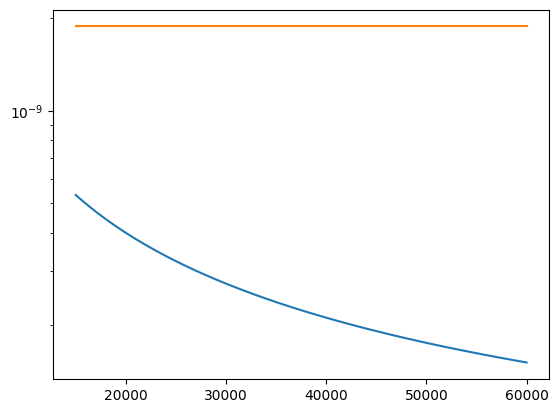

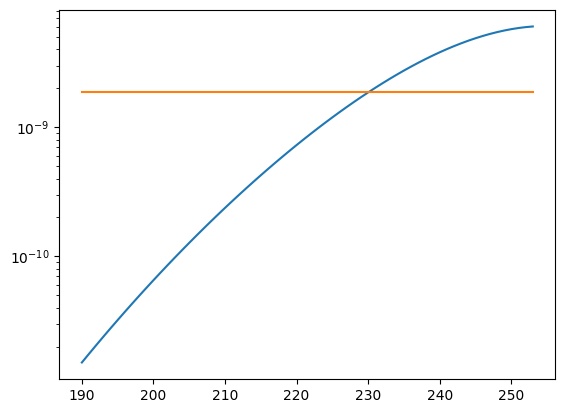

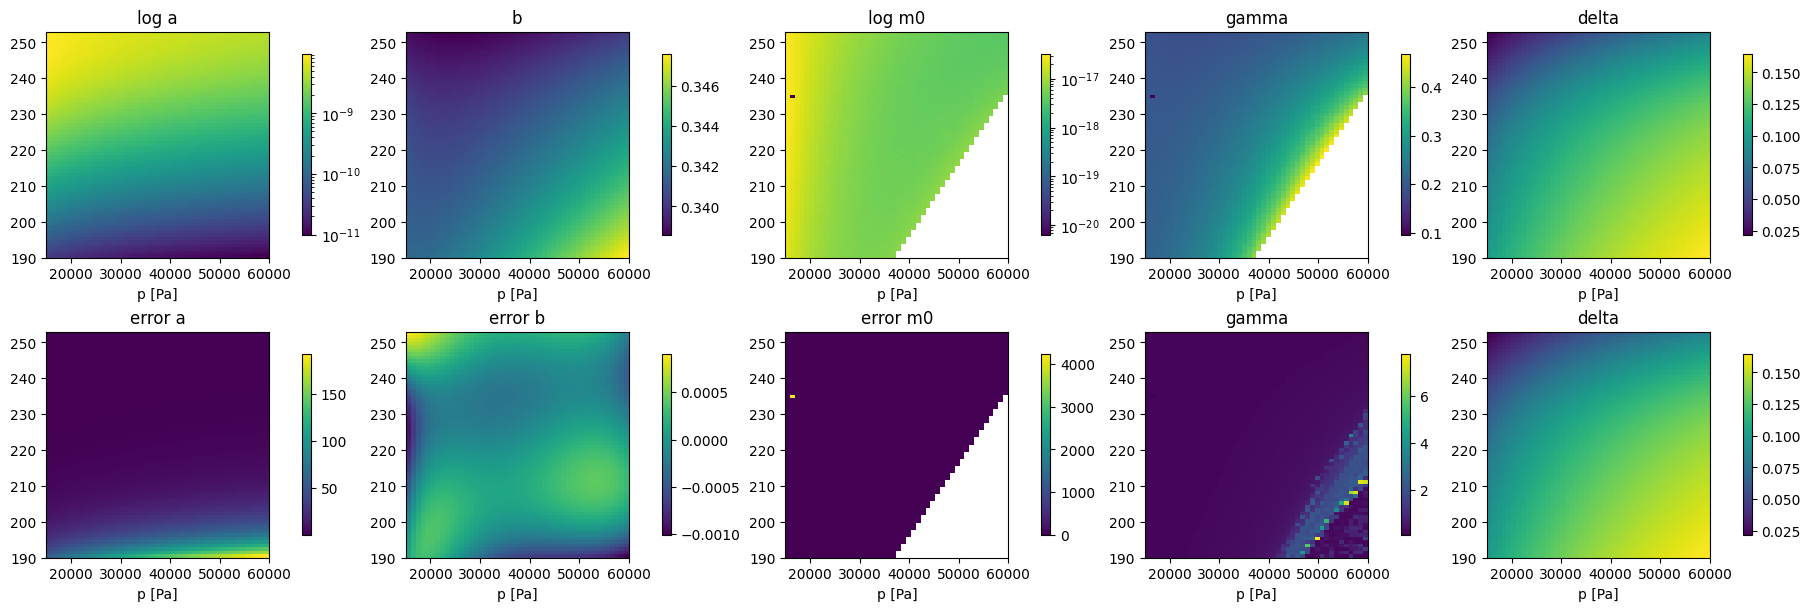

In [12]:
a=a.reshape(T.shape)
b=b.reshape(T.shape)
m0=m0.reshape(T.shape)
gamma=gamma.reshape(T.shape)
delta=delta.reshape(T.shape)
mask=(T>0.002*p+115)&(gamma<0.5)


with h5py.File('ice_growth_fits.hdf5','w') as f:
    f.create_dataset('p',data=p_vals)
    f.create_dataset('T',data=T_vals)
    f.create_dataset('a',data=a)
    f.create_dataset('b',data=b)
    f.create_dataset('m0',data=np.where(mask,m0,np.nan))
    f.create_dataset('gamma',data=np.where(mask,gamma,np.nan))
    f.create_dataset('delta',data=delta)

def fun_a(x,a,b,c,d,e,f):
    return a*np.exp(b*(x[1]-c)**2+d)*np.exp(e*x[0])/x[0]+f # elliptic integrand 

def fun_b(x,a,b,c,d,e,f,g):
    return a*x[0]**3+b*x[0]**2+c*x[0]+d*x[1]**2+e*x[1]+f*x[0]*x[1]+g

def fun_m0(x,a,b,c,d):
    return a*x[0]**b*(x[1])**c+d

def exp_fun(x,a,b,c,d,e):
    return a*np.exp(x[0]/b)/x[0]*np.exp(c*x[1]**2+d*x[1]+e)

pT=np.column_stack((p.ravel(),T.ravel())).T


mask=(T>0.002*p+115)&(gamma<0.5)
print(pT.shape)
a_params = curve_fit(fun_a, pT, a.ravel(), p0=(1e-3,-0.01,250,0,1/50000,0))[0]
print(a_params)
b_params = curve_fit(fun_b, pT, b.ravel(), p0=(1,1,1,1,1,1,1))[0]
print(b_params)
m0_params = curve_fit(fun_m0, pT[:,mask.ravel()], m0[mask].ravel(), p0=(1,-2.0,1.0,0))[0]
print(m0_params)
# Example arrays and limits
params = [
    ('log a', a, (None, None)),
    ('b', b, (None, None)),
    ('log m0', np.where(mask,m0,np.nan), (None, None)),
    ('gamma', np.where(mask,gamma,np.nan), (None, None)),
    ('delta', delta, (None, None)),
    ('error a', (fun_a(pT,*a_params).reshape(T.shape))/a, (None, None)),
    ('error b', (fun_b(pT,*b_params).reshape(T.shape)-b)/b, (None, None)),
    ('error m0',(np.where(T>0.002*p+115
                                ,(fun_m0(pT,*m0_params).reshape(T.shape)),np.nan)-m0)/m0, (None, None)),
    ('gamma', gamma, (None, None)),
    ('delta', delta, (None, None)),
]
print(T.shape,p.shape)
plt.semilogy(p[20],a[20])
plt.semilogy(p[20],fun_a(pT[:,20*46:21*46],*a_params))
plt.show()
plt.semilogy(T[:,20],a[:,20])
plt.semilogy(T[:,20],fun_a(pT[:,20::46],*a_params))
plt.show()


fig, axes = plt.subplots(2, 5, figsize=(18, 6), constrained_layout=True)

for ax, (name, arr, (vmin, vmax)) in zip(axes.ravel(), params):
    im = ax.imshow(
        arr,
        origin='lower',
        extent=(p_vals[0], p_vals[-1], T_vals[0], T_vals[-1]),
        aspect='auto',
        norm='log' if 'log' in name else None,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(name)
    ax.set_xlabel('p [Pa]')
    if ax is axes[0]:
        ax.set_ylabel('T [K]')
    fig.colorbar(im, ax=ax, shrink=0.8)

plt.show()



[1.31442548e+00 9.18952876e-01 6.35819751e-01 4.35391761e-01
 2.95263411e-01 1.98529746e-01 1.32546767e-01 8.80056682e-02
 5.81917715e-02 3.83642742e-02 2.52403322e-02 1.65824747e-02
 1.08840281e-02 7.13926425e-03 4.68094756e-03 3.06826500e-03
 2.01081488e-03 1.31764616e-03 8.63358213e-04 5.65666708e-04
 3.70608499e-04 2.42806551e-04 1.59073945e-04 1.04215789e-04
 6.82755574e-05 4.47296185e-05 2.93038011e-05 1.91978216e-05
 1.25770689e-05 8.23960891e-06 5.39800821e-06 3.53639152e-06
 2.31679202e-06 1.51779701e-06 9.94352341e-07 6.51428688e-07
 4.26769569e-07 2.79588945e-07 1.83166708e-07 1.19997744e-07
 7.86139497e-08 5.15022439e-08 3.37405909e-08 2.21044247e-08
 1.44812399e-08 9.48707382e-09 6.21525299e-09 4.07178972e-09
 2.66754573e-09 1.74758538e-09]
[1.82997529e+00 1.35086551e+00 9.93546678e-01 7.27595421e-01
 5.30134768e-01 3.83970771e-01 2.76187324e-01 1.97085909e-01
 1.39384818e-01 9.76137529e-02 6.76565329e-02 4.64079767e-02
 3.15206488e-02 2.12220761e-02 1.41839255e-02 9.42526

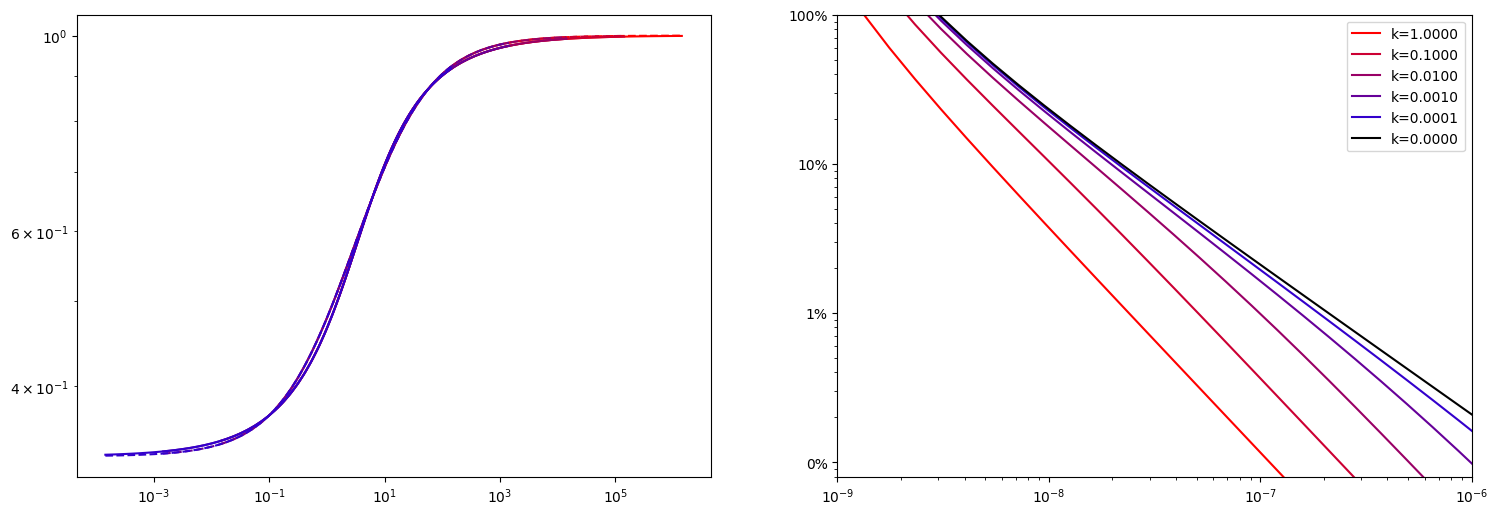

In [44]:
from matplotlib.ticker import PercentFormatter
from hygrometry import psat_ice, psat_water
from scipy.differentiate import derivative
from scipy.optimize import root

tstat=298.15
tsig=647.096
sigma_wa = 235.8*(1-tstat/tsig)**1.256*(1-0.625*(1-tstat/tsig))


def S(r,rd,kappa):
    rho_w=1000
    Rv=8.31/M_w
    aw = (r**3-rd**3)/(r**3-rd**3*(1-kappa))
    ak = 2 * sigma_wa / (Rv * tstat * rho_w)
    print(ak/r)
    return aw * np.exp(ak/r)

kappa=np.logspace(0,-4,5)

rd = 0.5*np.logspace(-9,-3,50)

fig=plt.figure(figsize=(18,6))
ax=fig.subplots(1,2)

sigma_wa=0.072
rho_w=1000
Rv=8.31/M_w



# differentiate
for i,k in enumerate(kappa):

    rstar = root(lambda r: ((r/rd)**3-1)/(r/rd)**2-np.sqrt((3*k*rd)/(2 * sigma_wa / (Rv * tstat * rho_w))),rd,method='lm',options={"eps":1e-10})
    # print(k,rstar.fun)
    red=np.array([1,0,0])
    blue=np.array([0,0,1])
    color=(1-i/len(kappa))*red+i/len(kappa)*blue


    x=(3*k*rd)/(2 * sigma_wa / (Rv * tstat * rho_w))
    rstar_guess = rd * (1 + x**(1/2)*(x**(2/3)+1.2)/(x**(2/3)+3.6))

    ax[0].loglog(x,(rstar.x/rd-1)/x**0.5,color=color)
    ax[0].loglog(x,(rstar_guess/rd-1)/x**0.5,color=color,linestyle='dashed')
    # ax[0].semilogx(x,(rstar.x-rstar_guess)/rstar.x,color=color)
    # ax[0].axvline((2* sigma_wa / (Rv * tstat * rho_w))/(3*k),color=color,linestyle='dashed')

    # ax[0].loglog(rd,r_guess,color='C1')


    ax[1].loglog(2*rd,100*(S(rstar.x,rd,k)-1),color=color,label=f'k={k:.4f}')
    # ax[1].loglog(rd,100*(S(r_guess,rd,k)-1))
    # ax[1].loglog(rd,rstar_guess)
    ax[1].set_ylim(0.08,100)
    ax[1].set_xlim(1e-9,1e-6)



ax[1].loglog(2*rd,100*S(rd+rd*1e-10,rd,0)-100,color='black',label='k=0.0000')
ax[1].yaxis.set_major_formatter(PercentFormatter(xmax=100))
plt.legend()
plt.show()

